# Redes Neuronales Recurrentes y Prophet para Predicción de Series Temporales (Core)


Descripción:

En este ejercicio, implementarás una red neuronal recurrente (RNN) utilizando LSTM para predecir valores futuros en una serie temporal. Además, se te pide que explores el uso de la herramienta Prophet, un modelo de predicción de series temporales desarrollado por Facebook, y compares los resultados obtenidos con los de la RNN.



Objetivo:

El objetivo es predecir los valores futuros de una serie temporal utilizando redes recurrentes y comparar su rendimiento con Prophet. Este ejercicio te permitirá explorar dos enfoques distintos para la predicción de series temporales.

# Selección del dataset:
  – Utiliza un dataset de series temporales de Kaggle, como el de “Air Quality Prediction” o cualquier otro relacionado con predicción de demanda, precios de acciones, etc. Puedes elegir el dataset que más se relacione con tus intereses.
  
  – Enlace sugerido: [Air Quality Prediction](https://www.kaggle.com/competitions/air-quality-prediction)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/11_Core_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   DEWP    41757 non-null  int64  
 2   TEMP    41757 non-null  float64
 3   PRES    41757 non-null  float64
 4   cbwd    41757 non-null  object 
 5   Iws     41757 non-null  float64
 6   Is      41757 non-null  int64  
 7   Ir      41757 non-null  int64  
 8   AQI     41757 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 2.9+ MB


## Diccionario de datos
No - un número de secuencia

DEWP - un punto de rocío

TEMP - temperatura

PRES - presión

cbwd - una dirección combinada del viento

Iws - velocidad acumulada del viento

Is - horas acumuladas de nieve

Ir - horas acumuladas de lluvia

AQI - un resultado del índice de calidad del aire

# 2. Preprocesamiento de datos:

  – Realiza una exploración inicial de la serie temporal, incluyendo la visualización de la tendencia y la estacionalidad si es aplicable.

  – Realiza un escalado de los datos, ya que las redes neuronales recurrentes se benefician de que los datos estén en un rango similar.

In [4]:
# Verificando si hay datos nulos (%)
print("Valores nulos:")
print((df.isnull().sum() * 100 / len(df)).round(2))
print("\n")

# Verificando si hay duplicados
print("Valores duplicados:")
print(df.duplicated().sum())
print("\n")

Valores nulos:
No      0.0
DEWP    0.0
TEMP    0.0
PRES    0.0
cbwd    0.0
Iws     0.0
Is      0.0
Ir      0.0
AQI     0.0
dtype: float64


Valores duplicados:
0




In [5]:
# Detectar outliers en variables numéricas
def outliers_IQR(df):
    # Filtrar solo columnas numéricas
    numeric_columns = df.select_dtypes(include=['number']).columns

    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)  # Primer cuartil
        Q3 = df[col].quantile(0.75)  # Tercer cuartil
        IQR = Q3 - Q1               # Rango intercuartílico

        # Definir los límites inferior y superior de los valores atípicos
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificar outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"\n🚩 Outliers detected in {col}: {outliers.shape[0]}")

        # Opcional: Remover outliers
        # df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Llamar a la función
outliers_IQR(df)


🚩 Outliers detected in No: 0

🚩 Outliers detected in DEWP: 0

🚩 Outliers detected in TEMP: 0

🚩 Outliers detected in PRES: 0

🚩 Outliers detected in Iws: 4893

🚩 Outliers detected in Is: 368

🚩 Outliers detected in Ir: 1739

🚩 Outliers detected in AQI: 1773


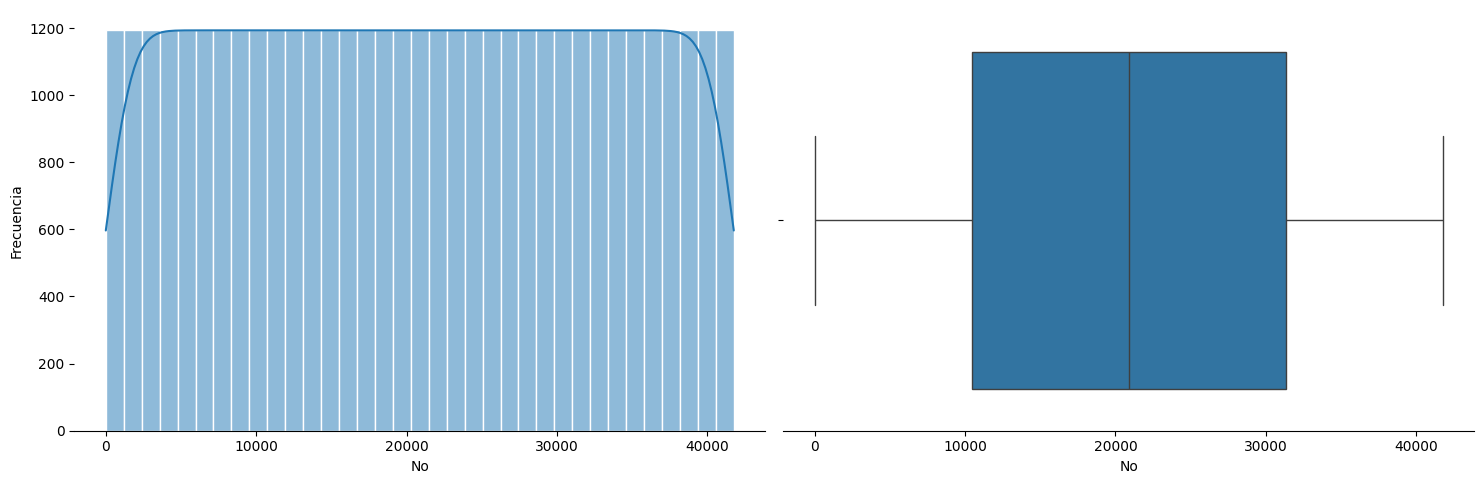

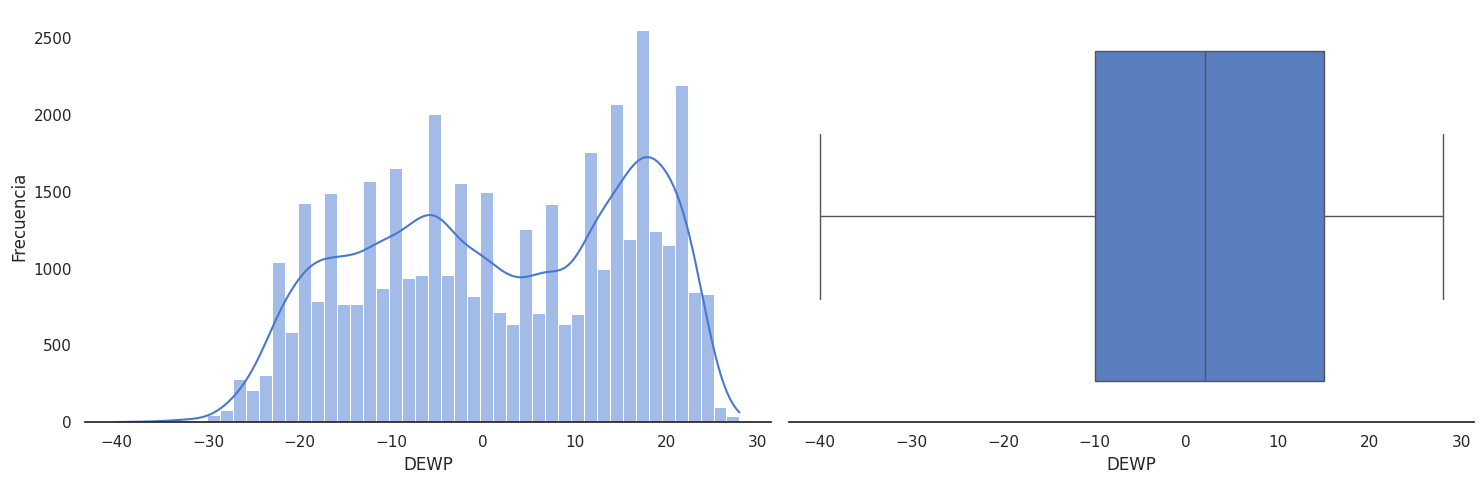

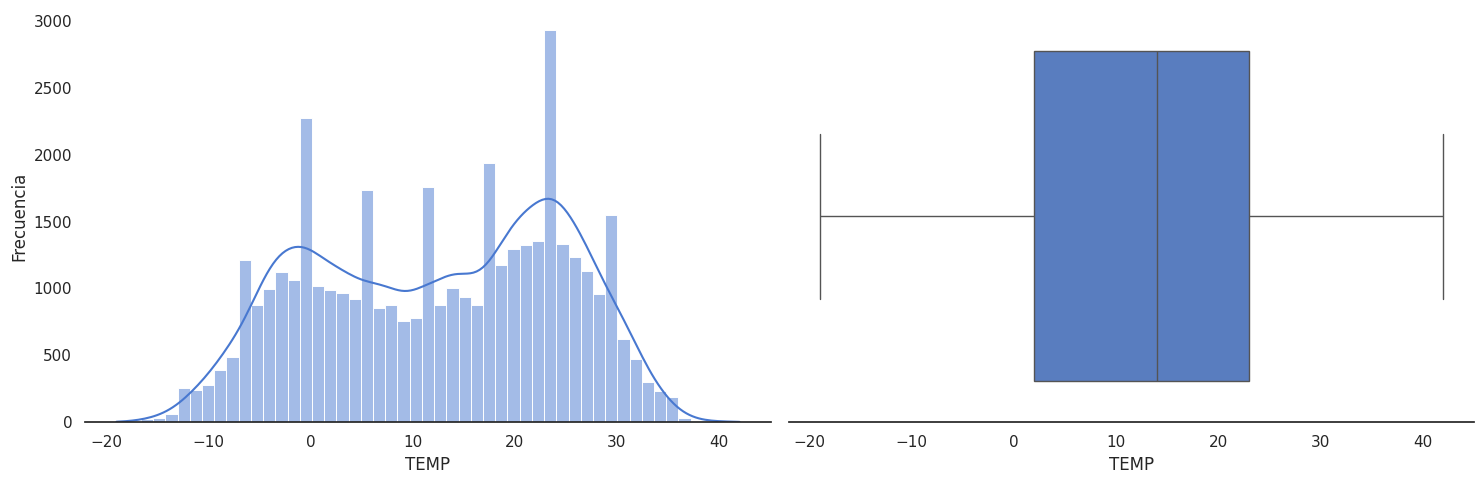

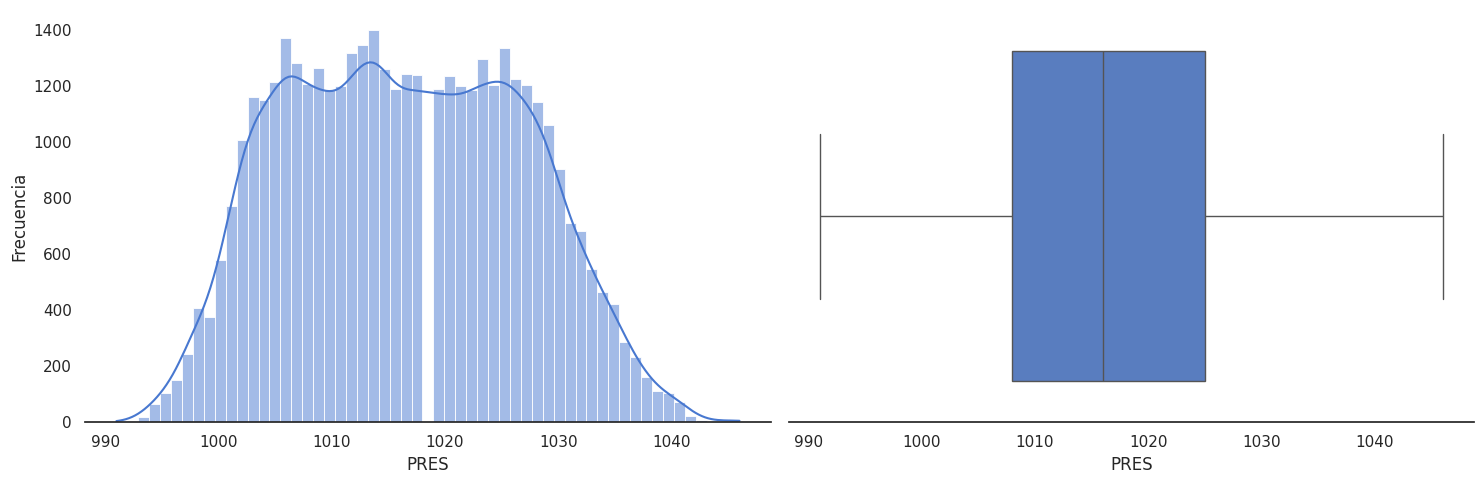

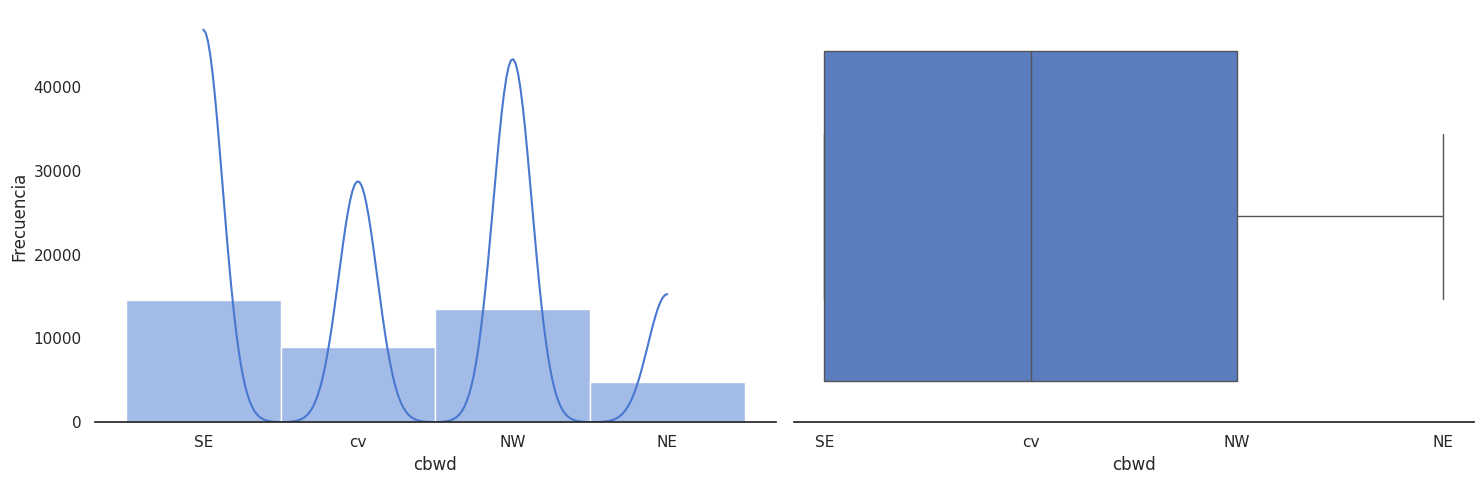

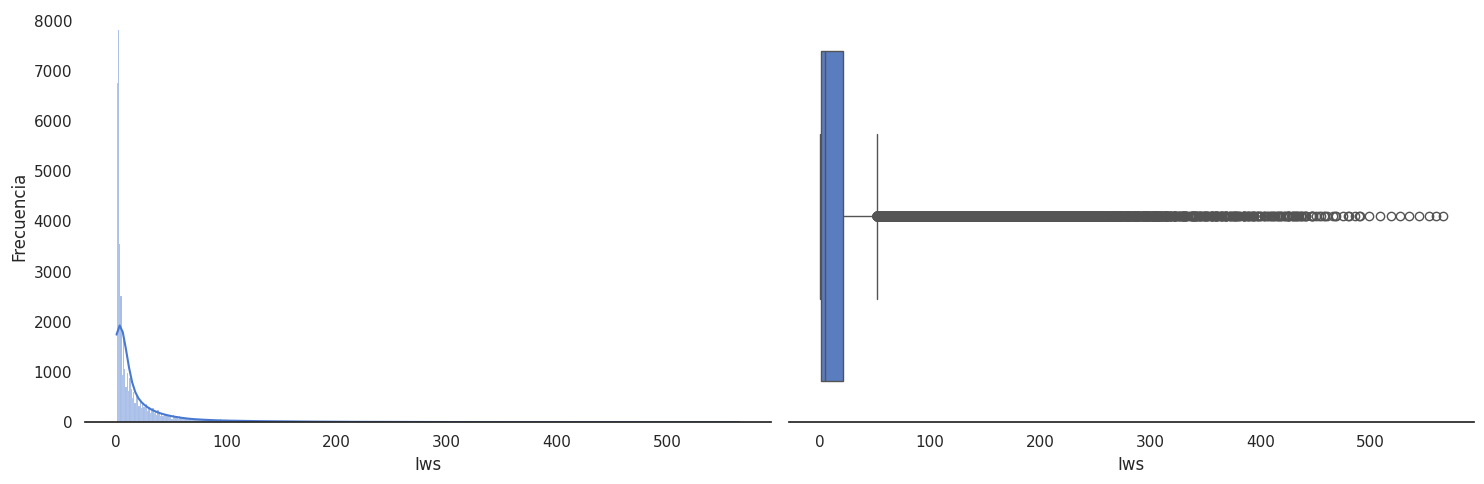

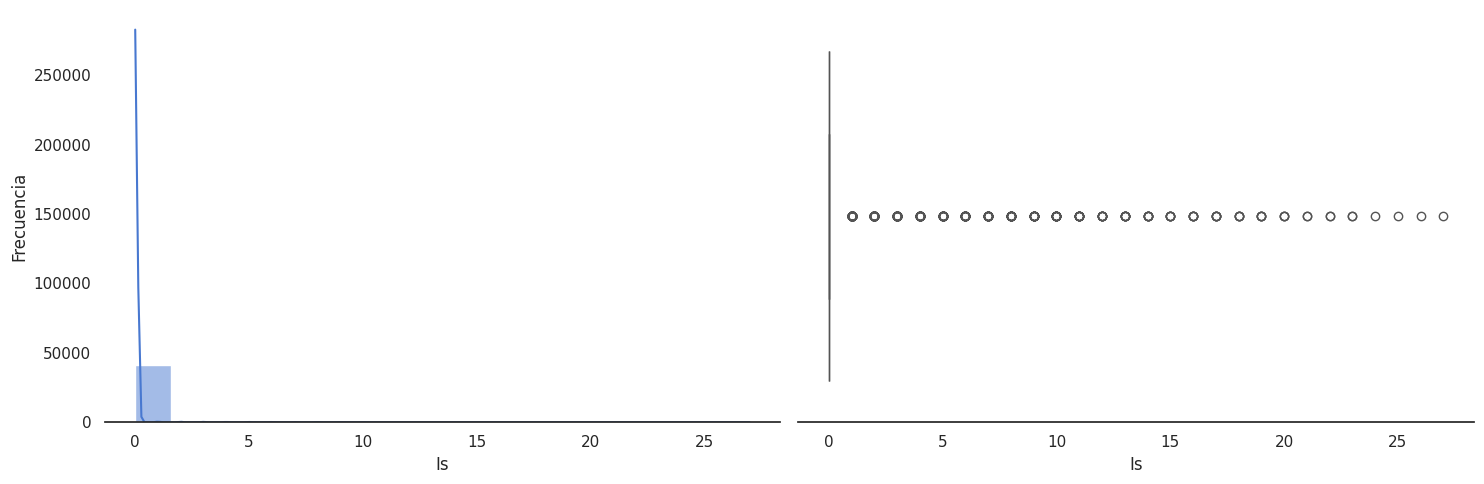

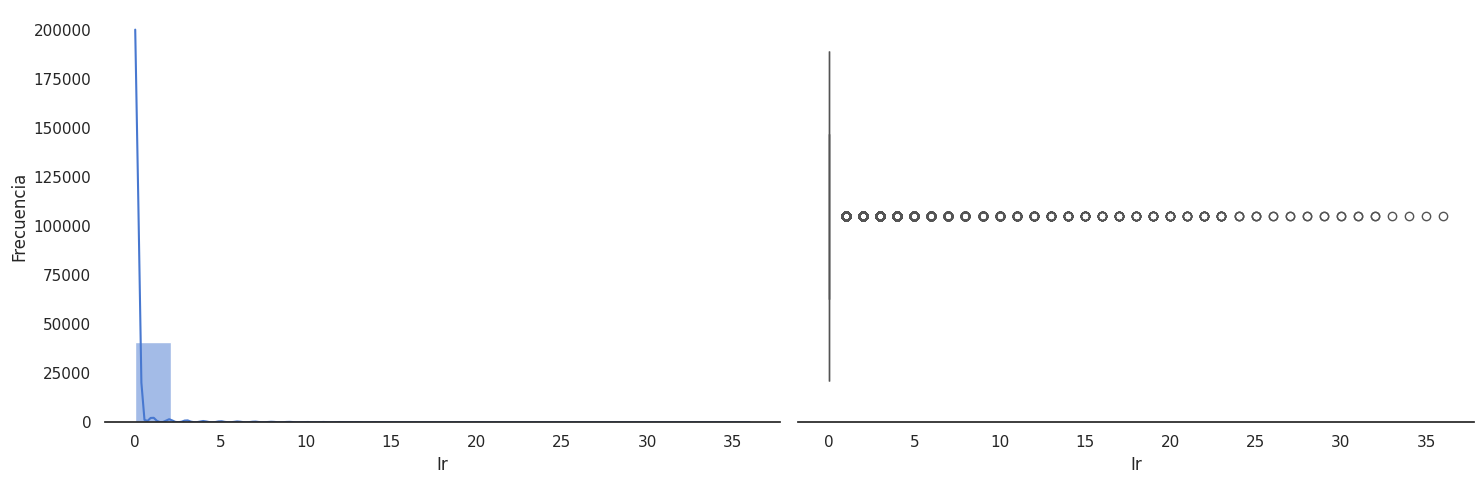

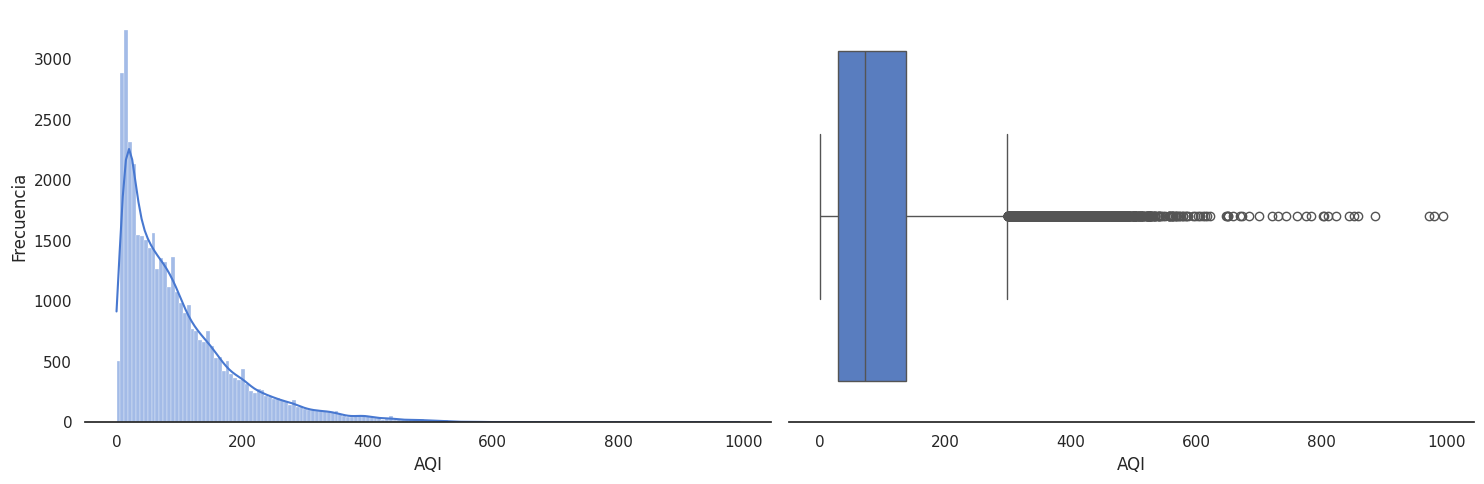

In [6]:
def vis_hist_boxplot(df):
    for i in df.columns:
        fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
        sns.set(style="white", palette="muted", color_codes=True)
        sns.despine(left=True)

        # Histograma con kde
        sns.histplot(data=df, x=i, kde=True, ax=ax[0]).set_xlabel(f"{i}")
        ax[0].set_ylabel('Frecuencia')
        # Boxplot
        sns.boxplot(data=df, x=i, ax=ax[1])

        plt.tight_layout()
        plt.show()

vis_hist_boxplot(df)

In [10]:
df.describe().round()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,AQI
count,41757.0,41757.0,41757.0,41757.0,41757.0,41757.0,41757.0,41757.0
mean,20879.0,2.0,12.0,1016.0,24.0,0.0,0.0,99.0
std,12054.0,14.0,12.0,10.0,50.0,1.0,1.0,92.0
min,1.0,-40.0,-19.0,991.0,0.0,0.0,0.0,0.0
25%,10440.0,-10.0,2.0,1008.0,2.0,0.0,0.0,29.0
50%,20879.0,2.0,14.0,1016.0,5.0,0.0,0.0,72.0
75%,31318.0,15.0,23.0,1025.0,22.0,0.0,0.0,137.0
max,41757.0,28.0,42.0,1046.0,565.0,27.0,36.0,994.0


In [15]:
# Eliminar la columna 'No'
df = df.drop('No', axis=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DEWP    41757 non-null  int64  
 1   TEMP    41757 non-null  float64
 2   PRES    41757 non-null  float64
 3   cbwd    41757 non-null  object 
 4   Iws     41757 non-null  float64
 5   Is      41757 non-null  int64  
 6   Ir      41757 non-null  int64  
 7   AQI     41757 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 2.5+ MB


In [17]:
# One Hot Encoding para cbwd
cbwd_dummies = pd.get_dummies(df['cbwd'], prefix='cbwd', dtype=int)
df = pd.concat([df, cbwd_dummies], axis=1)
df = df.drop('cbwd', axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEWP     41757 non-null  int64  
 1   TEMP     41757 non-null  float64
 2   PRES     41757 non-null  float64
 3   Iws      41757 non-null  float64
 4   Is       41757 non-null  int64  
 5   Ir       41757 non-null  int64  
 6   AQI      41757 non-null  int64  
 7   cbwd_NE  41757 non-null  int64  
 8   cbwd_NW  41757 non-null  int64  
 9   cbwd_SE  41757 non-null  int64  
 10  cbwd_cv  41757 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 3.5 MB


In [19]:
from sklearn.preprocessing import MinMaxScaler

# Selecciona las columnas numéricas que deseas escalar
numerical_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'AQI']

# Crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajusta el scaler a los datos y transforma las columnas seleccionadas
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Ahora las columnas numéricas están escaladas entre 0 y 1
print(df.head())


       DEWP      TEMP      PRES       Iws        Is   Ir       AQI  cbwd_NE  \
0  0.352941  0.245902  0.527273  0.002372  0.000000  0.0  0.129779        0   
1  0.367647  0.245902  0.527273  0.003947  0.000000  0.0  0.148893        0   
2  0.426471  0.229508  0.545455  0.005522  0.000000  0.0  0.159960        0   
3  0.485294  0.229508  0.563636  0.008690  0.037037  0.0  0.182093        0   
4  0.485294  0.229508  0.563636  0.010265  0.074074  0.0  0.138833        0   

   cbwd_NW  cbwd_SE  cbwd_cv  
0        0        1        0  
1        0        1        0  
2        0        1        0  
3        0        1        0  
4        0        1        0  


# 3. Implementación de RNN con LSTM:

  – Implementa una red LSTM para predecir la serie temporal. Utiliza una arquitectura simple con una capa LSTM y una capa densa para predecir el valor futuro de la serie temporal.
  
  – Asegúrate de dividir los datos en conjuntos de entrenamiento y prueba, utilizando las primeras partes de la serie para entrenar el modelo y las últimas partes para probar la precisión de las predicciones.

In [20]:
# Función para crear secuencias de datos
def create_sequences(data, target, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

# Longitud de la secuencia (ventana de tiempo)
sequence_length = 50  # Este valor se debería ajustar dependiendo de____

# Crear secuencias para entrenamiento y prueba
X, y = create_sequences(df[numerical_cols].values, df['AQI'].values, sequence_length)

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)  # 80% para entrenamiento, 20% para prueba
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Verificar las formas de los datos
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)

Forma de X_train: (33365, 50, 7)
Forma de y_train: (33365,)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Construir el modelo
model = Sequential()

# Capa LSTM
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(numerical_cols))))  # 50 neuronas en la capa LSTM

# Capa densa de salida
model.add(Dense(1))  # Una neurona para predecir el valor de AQI

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')  # Usamos el optimizador Adam y el error cuadrático medio (MSE) como función de pérdida

# Resumen del modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          11,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,651 (45.51 KB)

 Trainable params: 11,651 (45.51 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=20,  # Número de épocas (puedes ajustar este valor)
    batch_size=32,  # Tamaño del lote (puedes ajustar este valor)
    validation_data=(X_test, y_test),  # Datos de validación
    verbose=1  # Muestra el progreso del entrenamiento
)

Epoch 1/20
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.0023 - val_loss: 5.4722e-04
Epoch 2/20
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - loss: 7.2331e-04 - val_loss: 5.2195e-04
Epoch 3/20
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 5.7955e-04 - val_loss: 4.6785e-04
Epoch 4/20
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - loss: 5.7080e-04 - val_loss: 4.4873e-04
Epoch 5/20
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - loss: 5.5844e-04 - val_loss: 4.5701e-04
Epoch 6/20
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 5.5736e-04 - val_loss: 4.9877e-04
Epoch 7/20
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 5.3890e-04 - val_loss: 4.4566e-04
Epoch 8/20
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - loss: 5.3468e-04 - val_loss: 4.6201e-04
Epoch 9/20
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 6.1365e-04 - val_loss: 4.4249e-04
Epoch 10/20
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 5.5163e-04 - val_loss: 4.6497e-04
Epoch 11/20
1043/1043 ━

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Crear un scaler específico para la columna AQI
scaler_aqi = MinMaxScaler(feature_range=(0, 1))

# Escalar solo la columna AQI
df['AQI_scaled'] = scaler_aqi.fit_transform(df[['AQI']])

# Verificar
print(df[['AQI', 'AQI_scaled']].head())

        AQI  AQI_scaled
0  0.129779    0.129779
1  0.148893    0.148893
2  0.159960    0.159960
3  0.182093    0.182093
4  0.138833    0.138833


In [27]:
# Predecir con el modelo
y_pred_scaled = model.predict(X_test)

# Invertir el escalado de las predicciones y los valores reales
y_pred_original = scaler_aqi.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_aqi.inverse_transform(y_test.reshape(-1, 1))

# Calcular métricas de error
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
RMSE: 0.02063484312329289
MAE: 0.011588619967551362


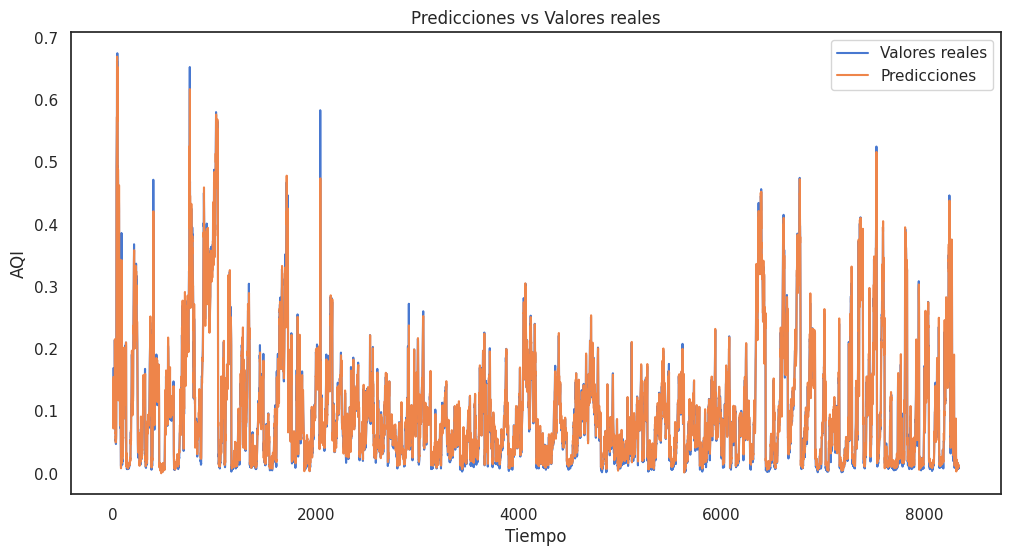

In [28]:
# Visualizar las predicciones vs los valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Valores reales')
plt.plot(y_pred_original, label='Predicciones')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Tiempo')
plt.ylabel('AQI')
plt.legend()
plt.show()

# 4. Uso de Prophet:

  – Instala y utiliza Prophet para predecir la misma serie temporal. Prophet es un modelo que maneja fácilmente tendencias y estacionalidades, por lo que es ideal para comparación con redes recurrentes.
  
  – Entrena Prophet con los mismos datos que utilizaste para la red LSTM y realiza predicciones en el conjunto de prueba.

In [30]:
pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 46.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setu

In [33]:
print(df.columns)

Index(['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'AQI', 'cbwd_NE', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'AQI_scaled'],
      dtype='object')


# 5. Comparación de resultados:

  – Compara las predicciones de la red LSTM con las predicciones de Prophet. Utiliza métricas como el RMSE (Root Mean Squared Error) o el MAE (Mean Absolute Error) para medir la precisión de ambos modelos.
  
  – Visualiza las predicciones de ambos modelos superpuestas a la serie temporal original para ver cuál se ajusta mejor a los datos.

# 6. Análisis y discusión:

  – Discute cuál de los modelos ofrece mejores resultados en este caso particular. ¿Por qué crees que Prophet o la red LSTM tuvieron un mejor rendimiento?
  
  – Reflexiona sobre las ventajas y desventajas de cada enfoque para la predicción de series temporales.

## Análisis

Se realizó la carga de datos del dataset sugerido, en este no hay ni nulos ni duplicados, pero en algunas variables si hay outliers, que si bien, en algunos casos son bastantes, son viables y validos dado el tipo de estudio, mas cuando la variable respuesta responde también a estos

Así se realizó la transformaciones, codificaciones y escalados requeridos para poder implementar las redes recurrentes.

De manera tal solo se pudo implementar LSTM y Prophet no, porque se requiere una escala de tiempo, fecha o date, y el dataset no la trae implementada o medida, y en opciones que revisé, ninguna me convenció.

Así que se realizará solo análisis de LSTM: se usaron 50 neuronas en la capa LSTM y 1 capa densa, obteniendo un perdimiento bajo, lo que indica que el modelo está aprendiendo bien y no se está sobre ajustando, generalizando bien a datos no vistos. Además, las métricas de error son bajas, indicando que las predicciones del modelo están cerca de los valores reales y de manera precisa (RMSE: 0.0206 y MAE: 0.0116)

Al momento de revisar las predicciones de AQI_scaled, se ve que los valores están muy cercas de los reales AQI, confirmado también por las métricas

Conclusiones
1.	Rendimiento del Modelo:

- El modelo LSTM tiene un rendimiento excelente, como lo indican las métricas de error (RMSE y MAE muy bajos).
-	La pérdida de entrenamiento y validación es muy baja, lo que sugiere que el modelo no está sobreajustando y generaliza bien a datos no vistos.

2.	Calidad de las Predicciones:
-	Las predicciones están muy cerca de los valores reales, lo que indica que el modelo es preciso y confiable.
-	El modelo es capaz de capturar las relaciones temporales en los datos, lo que es crucial para predecir series temporales.

3.	Arquitectura del Modelo:
-	La arquitectura es simple pero efectiva, con una capa LSTM y una capa densa. Esto es adecuado para tu problema y evita la complejidad innecesaria.
-	El número de parámetros (11,651) es manejable y no indica riesgo de sobreajuste.

4.	Escalado de los Datos:
-	El escalado de los datos (MinMaxScaler) ha funcionado bien, ya que las predicciones están en el rango correcto y las métricas de error son bajas.



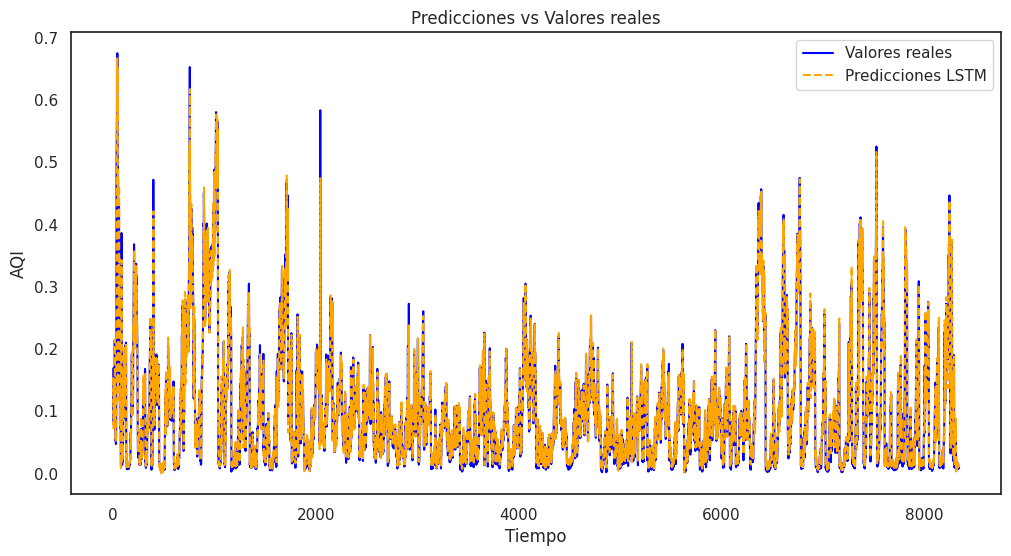

In [35]:
# Visualizar las predicciones vs los valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Valores reales', color='blue')
plt.plot(y_pred_original, label='Predicciones LSTM', color='orange', linestyle='--')
plt.title('Predicciones vs Valores reales')
plt.xlabel('Tiempo')
plt.ylabel('AQI')
plt.legend()
plt.show()